In [ ]:
#--------------------------------
# General Analysis Settings

# basepath: This defines the base directory for storing all the generated analysis files. 
# It should have at least 10-20 GB free. 
basepath = '/data/GCE_sys/'

# tag: All the generated files carry this tag. Should be descriptive of analysis.
tag = 'P8R2_tim_mask_front' 

#--------------------------------
# Energy Binning Settings
# The energy binning by default matches that of Calore et al 2014 (see 1409.0042 Eq.2 and discussion)
# This consists of a few linear spaced bins at low energies followed by a rescursive binning definition.
# If custom binning is required, just set the bin edges using prefix_bins=... and change n_bins=0
prefix_bins=np.array([119.432* 10**(i/10.) for i in range(35)]) # Fixed bins go here and are prepended to any additional recursive bins
# These 4 settings are for recursive bin definitions.  To disable set n_bins=0
n_bins = 0 # number of recursive bins
E_min = 5e2 # Starting recusrion energy
E_max = 5e5 # Max recursion energy
gamma = 1.45 # Recursion index. 


print prefix_bins

#--------------------------------
# Spatial Binning
healpix_order = 8 # Healpix order.  8 gives ~0.24 degree pixel edge width.  Increase of 1 halves the bin size.

#--------------------------------
# Fermitools settings

# phfile input to gtselect. Can be merged photon file or a text file containing paths of each weekly file
#phfile_raw = '/data/fermi_data_1-8-14/phfile.txt' 
phfile_raw = '/data/fermi_data_6-26-15/phfile.txt' 


# scfile [filename]
#           Spacecraft data file containing information such as the spacecraft
#           pointing as a function of time. This file could be generated by
#           gtorbsim for simulated observations (see the gtorbsim help for further
#           explanation) or it can be obtained from the FERMI
#           Science Support Center (FSSC) website for real observations.
scfile = '/data/fermi_data_1-8-14/lat_spacecraft_merged.fits' # Path to spacecraft file


# (evclass) [integer] 
#          Event class selection for pass 7 reprocessed data. The 
#          default is 2 (source class). Other values are 0 for transient
#          data, 3 for the clean data class and 4 for the ultraclean data
#          class. 1 is currently unused. 
#evclass = 3 # FermiTools evclass
evclass = 256 # FermiTools evclass
evtype='1'

#     (convtype) [integer]
#          Conversion type. This parameter screens events based on which
#          portion of the instrument the incident gamma-ray pair conversion
#          event occurred. 0=Front, 1=Back, -1=both (defalt value). Refer 
#          to the Cicerone manual for details
#          (http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone).
convtype = 0

# filter [string]
#           This is the filter expression. The cuts are make using C-style
#           relational syntax like for example: ! (not), && (and), || (or), !=
#           (different), >, <, >=, <=, abs(), cos(), sin(), etc. Default is 
#           "DATA_QUAL>0 && LAT_CONFIG==1 && ABS(ROCK_ANGLE)<52".

gtfilter = 'DATA_QUAL>0 && LAT_CONFIG==1 && ABS(ROCK_ANGLE)<52' # gtmktime cut

# The fermi instrument response function.  Can get full list via command gtirfs
# ******MAKE SURE THIS MATCHES evclass and convtype above!************
# Some common ones....
# P7REP_CLEAN_V15 ( = P7REP_CLEAN_V15::FRONT + P7REP_CLEAN_V15::BACK )
# P7REP_CLEAN_V15::BACK
# P7REP_CLEAN_V15::FRONT
# P7REP_SOURCE_V15 ( = P7REP_SOURCE_V15::FRONT + P7REP_SOURCE_V15::BACK )
# P7REP_SOURCE_V15::BACK
# P7REP_SOURCE_V15::FRONT
# P7REP_ULTRACLEAN_V15 ( = P7REP_ULTRACLEAN_V15::FRONT + P7REP_ULTRACLEAN_V15::BACK )
# P7REP_ULTRACLEAN_V15::BACK
# P7REP_ULTRACLEAN_V15::FRONT
#irf = 'P7REP_CLEAN_V15' 
irf = 'P8R2_CLEAN_V6::FRONT' 


# zmax [double]
#          Maximum apparent zenith angle (degrees). It ranges from 0 to 180 (default).
zmax = 90  # Max zenith angle cut

#---------------------------------------------------------
# Some file paths containing fermi data. 

# path to 3FGL file (or 2FGL)
# can download this at http://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/gll_psc_v14.fit
#      (2FGL is at at: http://fermi.gsfc.nasa.gov/ssc/data/access/lat/2yr_catalog/gll_psc_v08.fit)
fglpath = '/data/gll_psc_v16.fit' # 
#fglpath = '/data/gll_psc_v08.fit' # 

# Path to a fermi diffuse model.  Used only to calculate point source masking per Calore et al.
# Can get this at http://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html
#path_to_diffuse_model = '/home/carlson/fermitools/refdata/fermi/galdiffuse/gll_iem_v05.fits'
path_to_diffuse_model = '/data/fermi_background_models/gll_iem_v06.fits'



#---------------------------------------------------------
# Run this thing....
from Analysis import Analysis

A = Analysis( E_min, E_max, 2**healpix_order, gamma, n_bins, prefix_bins, tag, basepath, phfile_raw,
                    scfile, evclass, convtype,  zmax, irf, fglpath, gtfilter,  '/data/Extended_archive_v15/Templates/', evtype)

A.GenFermiData(runscript=True)

A.GenExposureMap()

# #------------------------------------------------------------------------
# # Extended source template
A.PopulateROI([0,0],radius=45, fix_radius=360, include_point=False)
master = np.zeros(A.templateList['W51C'].healpixCube.shape)
for key, t in A.templateList.items():
     master += t.healpixCube.toarray()
#------------------------------------------------------------------------

A.GenPointSourceTemplate(pscmap=(A.basepath + '/PSC_' + A.tag + '_fgl3.npy'), l_range=[-45,45], b_range=[-45,45])
master += np.load(A.basepath + '/PSC_' + A.tag + '_fgl3.npy')
np.save(A.basepath + '/PSC_' + A.tag + '_fgl3_with_ext.npy', master)






# A.GenPointSourceTemplate()
# A.GenPointSourceTemplate(pscmap=(A.basepath + '/PSC_' + A.tag + '_fgl2.npy'))
# A.GenPointSourceTemplate()
A.BinPhotons(outfile='binned_photons_'+A.tag+'.npy')
A.AddFermiDiffuseModel(diffuse_path=path_to_diffuse_model,
                     outfile='fermi_diffuse_'+A.tag+'.npy', multiplier=1.)

[  1.19432000e+02   1.50355980e+02   1.89286964e+02   2.38298169e+02
   2.99999620e+02   3.77677146e+02   4.75467356e+02   5.98577937e+02
   7.53564976e+02   9.48682097e+02   1.19432000e+03   1.50355980e+03
   1.89286964e+03   2.38298169e+03   2.99999620e+03   3.77677146e+03
   4.75467356e+03   5.98577937e+03   7.53564976e+03   9.48682097e+03
   1.19432000e+04   1.50355980e+04   1.89286964e+04   2.38298169e+04
   2.99999620e+04   3.77677146e+04   4.75467356e+04   5.98577937e+04
   7.53564976e+04   9.48682097e+04   1.19432000e+05   1.50355980e+05
   1.89286964e+05   2.38298169e+05   2.99999620e+05]
Run this script to generate the required fermitools files for this analysis.
The script can be found at /data/GCE_sys//GenFermiData_P8R2_tim_mask_front_.sh
Get a beer. This will take a while...


In [ ]:
#A.AddPointSourceTemplate()

A.GenPointSourceTemplate(pscmap=(A.basepath + '/PSC_' + A.tag + '_fgl3.npy'), l_range=[-45,45], b_range=[-45,45])

# A.AddFermiDiffuseModel(diffuse_path=path_to_diffuse_model,
#                       infile='fermi_diffuse_'+A.tag+'.npy', multiplier=1.)

In [ ]:
# A.CalculatePixelWeights(diffuse_model='fermi_diffuse_'+A.tag+'.npy',psc_model='PSC_' + A.tag + '_fgl3_with_ext.npy',
#                         alpha_psc=5., f_psc=0.1)


A.CalculatePixelWeights(diffuse_model='fermi_diffuse_'+A.tag+'.npy',psc_model='PSC_' + A.tag + '_fgl3.npy',
                        alpha_psc=5., f_psc=0.1)

In [ ]:
import healpy

cartesian_mask = []
for i in range(A.n_bins):
    cartesian_mask.append( healpy.cartview(A.psc_weights[i], latra=[-7.5,7.5],lonra=[-7.5,7.5], return_projected_map=True, xsize=300) )
    

    

In [ ]:
#np.save('cartesian_psc_mask_15x15.npy', np.array(cartesian_mask).astype(np.float32))
np.save('cartesian_psc_mask_FRONT_15x15.npy', np.array(cartesian_mask).astype(np.float32))

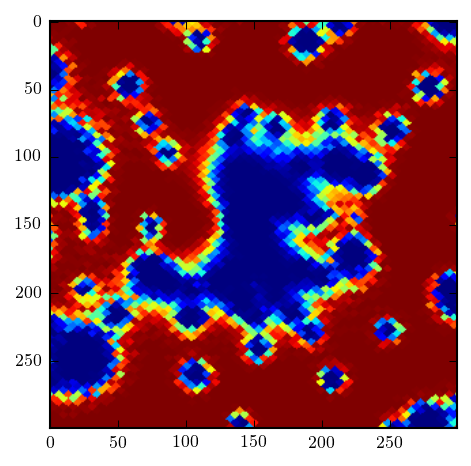

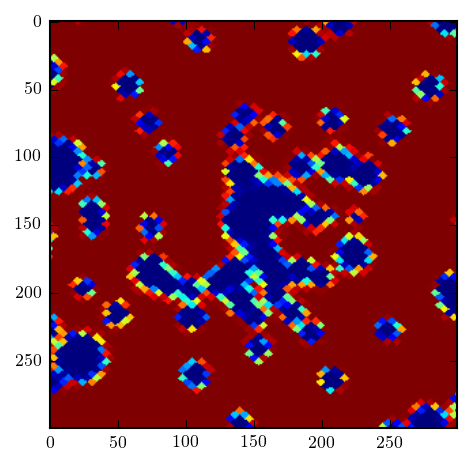

In [16]:
psc_mask = np.load('cartesian_psc_mask_15x15.npy')
psc_mask_psf3 = np.load('cartesian_psc_mask_PSF3_15x15.npy')

plt.imshow(psc_template[10])
plt.show()
plt.imshow(psc_template_psf3[10])


ValueError: Wrong pixel number (it is not 12*nside**2)

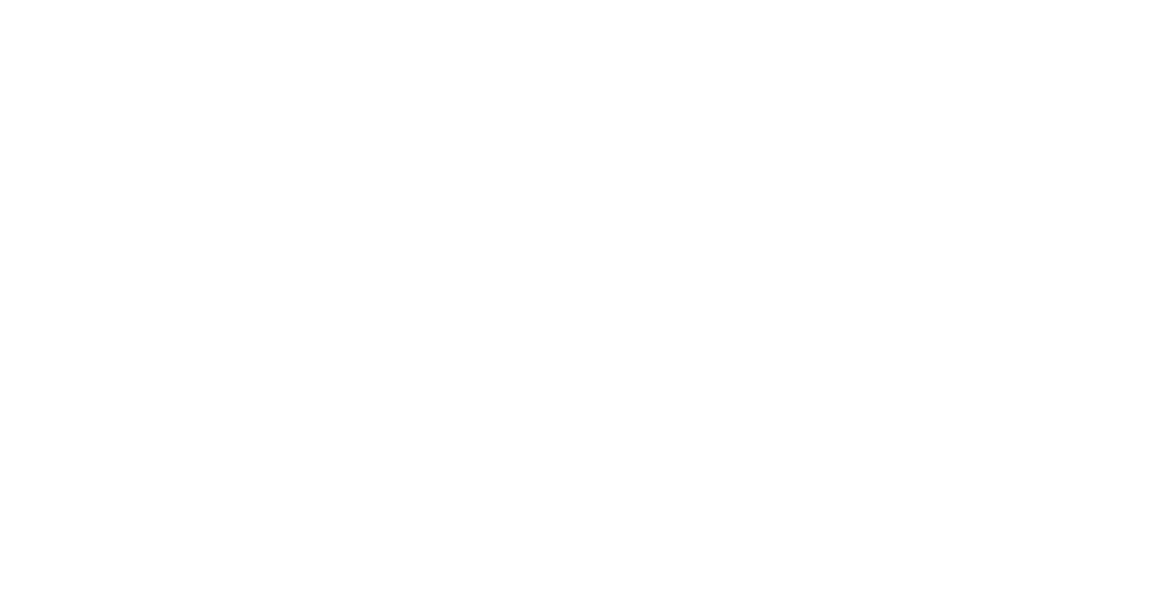

In [12]:

import healpy
healpy.cartview(psc_template[5],latra=[-15,15],lonra=[-15,15], return_projected_map=True, xsize=300)
healpy.cartview(psc_template_psf3[5],latra=[-15,15],lonra=[-15,15], return_projected_map=True, xsize=300)

plt.hlines(0,-15,15)
plt.vlines(0,-15,15)






In [10]:
healpy.cartview(A.psc_weights[10])

In [21]:
healpy.cartview(A.psc_weights[i], latra=[-15,15],lonra=[-15,15], return_projected_map=True, xsize=300) 

TypeError: 'NoneType' object has no attribute '__getitem__'

In [6]:
np.load('fermi_diffuse_'+A.tag+'.npy').shape

(34, 786432)

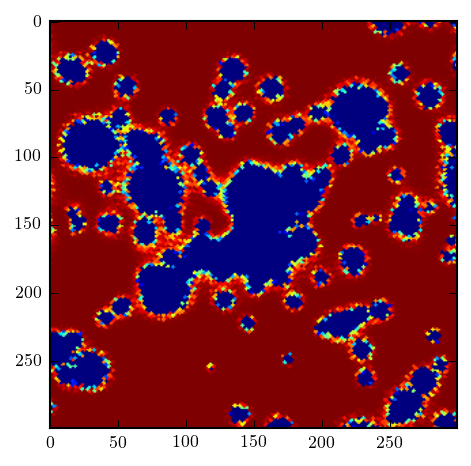

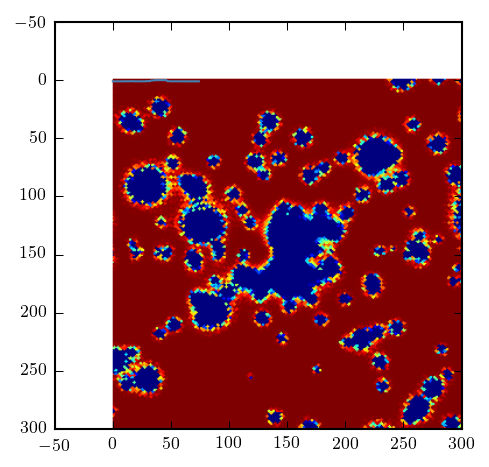

In [33]:

plt.imshow(np.load('cartesian_psc_mask_15x15.npy')[10], vmin=.9)
plt.show()
plt.imshow(np.load('cartesian_psc_mask_15x15.npy')[10], vmin=.5)


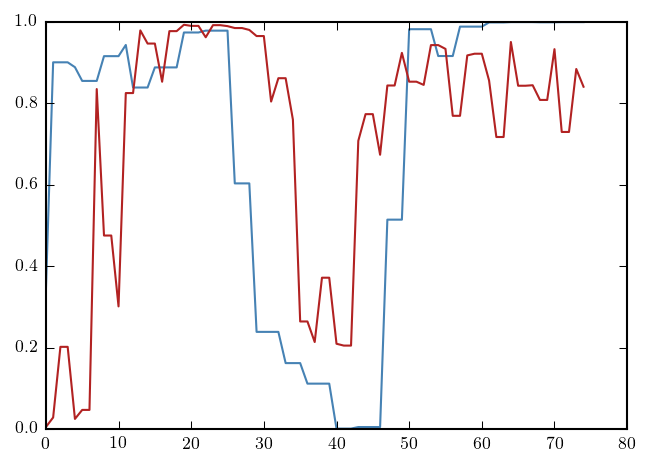

In [54]:
plt.plot(np.load('cartesian_psc_mask_15x15.npy')[5,25,:75])
plt.plot(np.load('cartesian_psc_mask_15x15.npy')[5,:75,257])

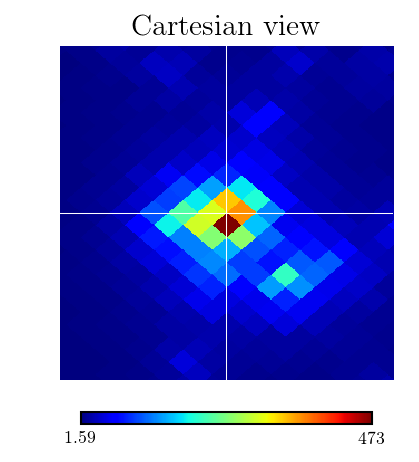

In [73]:

A.AddPointSourceTemplate(pscmap='PSC_P8R2_tim_mask_fgl3.npy')

healpy.cartview(A.templateList['PSC'].healpixCube[10],latra=[-2,2],lonra=[-2,2], return_projected_map=True, xsize=300,hold=True) 


plt.hlines(0,-15,15,color='w', linewidth=0.5)
plt.vlines(0,-15,15,color='w', linewidth=0.5)

[-1.    -0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125  0.     0.125
  0.25   0.375  0.5    0.625  0.75   0.875  1.     1.125  1.25   1.375  1.5
  1.625  1.75   1.875  2.     2.125  2.25   2.375  2.5    2.625  2.75
  2.875  3.   ]


/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: divide by zero encountered in log


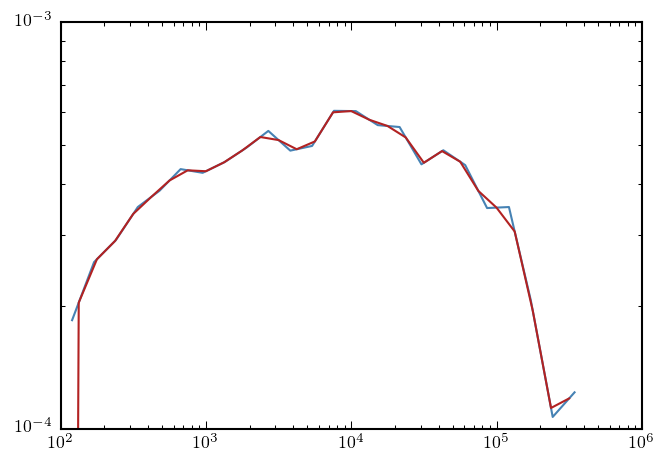

In [3]:
import Tools
from scipy.integrate import quad




def AddFermiBubbleTemplate(self, template_file='./bubble_templates_diskcut30.0.fits',
                               spec_file='bubble_spec_apj_793_64.dat', fixSpectrum=False, fixNorm=False):
        """
        Adds a fermi bubble template to the template stack.

        :param template_file: Requires file 'bubble_templates_diskcut30.0.fits'
            style file (from Su & Finkbeiner) with an extension table with a NAME column containing "Whole bubble"
            and a TEMPLATE column with an order 8 healpix array.
        :param spec_file: filename containing three columns (no header).  First col is energy in MeV, second is
            dN/dE in units (s cm^2 sr MeV)^-1 third is the uncertainty in dN/dE in (s cm^2 sr MeV)^-1.
        :param fixSpectrum: If True, the spectrum is not allowed to float.
        """

        # Load the template and spectrum
        hdu = pyfits.open(template_file)
        bub_idx = np.where(hdu[1].data['NAME'] == 'Whole bubble')
        bubble = hdu[1].data['TEMPLATE'][bub_idx][0].clip(0,1)
        #print min(bubble), max(bubble)

        # Resize template if need be.
        nside_in = int(np.sqrt(bubble.shape[0]/12))
        if nside_in != self.nside:
            bubble = Tools.ResizeHealpix(bubble, self.nside, average=True)

        energy, _,_,dnde, dnde_unc,_,_ = np.genfromtxt(spec_file,skip_header=1).T
        
        plt.loglog(energy*1e3, dnde/1e7*1e3)
        
        
        
        
        fluxinterp = lambda E: np.exp(np.interp(np.log(E), np.log(energy), np.log(dnde), right=-20,left=-20 ))
        
        
        #print dnde
        energies = np.logspace(-1,3,33)
        print np.log10(energies)
        
        healpixcube = np.zeros((len(energies), 12*self.nside**2))
        
        for i_E, E in enumerate(energies): 
            
            
            healpixcube[i_E] = bubble*fluxinterp(E)/1e7 / E**2  /1e3
        
        
        energy = energy*1e3
        energies = energies*1e3
        
        plt.loglog(energies, energies**2 * np.max(healpixcube, axis=1))
        plt.ylim(1e-4)
        return energies, healpixcube
        
energies, bubs = AddFermiBubbleTemplate(A)








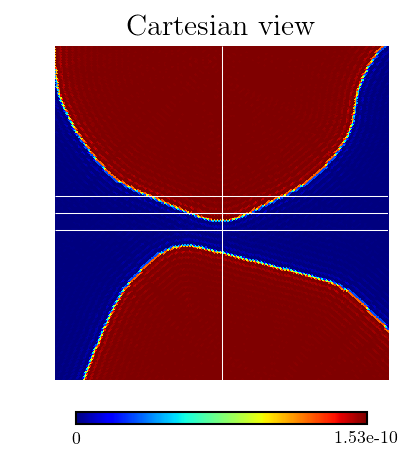

In [12]:
healpy.cartview(bubs[10], hold=True, latra=[-20,20], lonra=[-20,20])
plt.hlines([-2,0,2],-20,20,color='w', linewidth=.5)
plt.vlines(0,-20,20,color='w', linewidth=.5)



In [114]:
import h5py
h5 = h5py.File('new/mod_s_42_XCO_P8.hdf5')

1.333521432163324

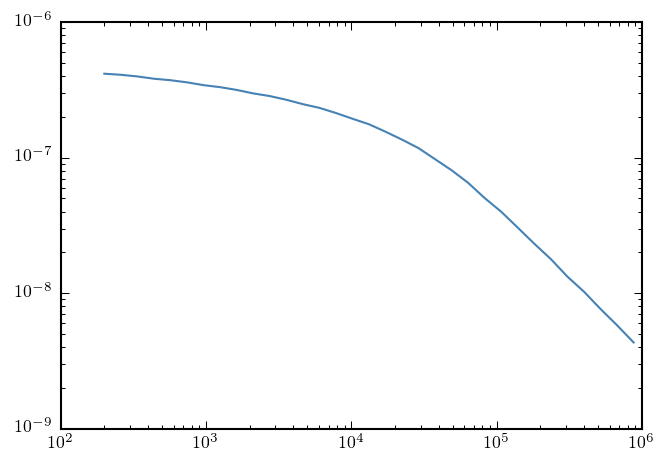

In [173]:
plt.loglog(h5['templates/energies'][...],h5['templates/energies'][...]**2*np.average(h5['templates/ics_cmb'][...]/1e3,axis=1))

# HDF5 templates formatted dnde in MeV^-1


10**.125

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
[ 2.     2.125  2.25   2.375  2.5    2.625  2.75   2.875  3.     3.125
  3.25   3.375  3.5    3.625  3.75   3.875  4.     4.125  4.25   4.375  4.5
  4.625  4.75   4.875  5.     5.125  5.25   5.375  5.5    5.625  5.75
  5.875  6.   ]


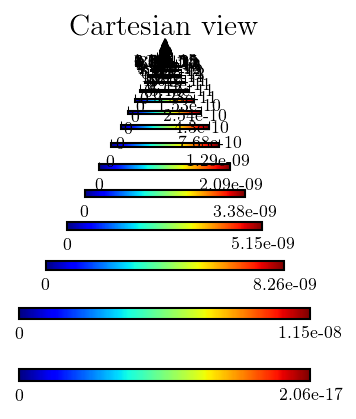

In [4]:
import h5py, healpy, pyfits
import numpy as np
import sys
import subprocess 
import os
from matplotlib import pyplot as plt

def Healpix2Cartesian(hpixcube):                        
    # Read from hdf5 file
    
    cartcube = np.zeros((hpixcube.shape[0], 721,1440), dtype=np.float32)
    for i in range(hpixcube.shape[0]):
        cartcube[i] = healpy.cartview(hpixcube[i], hold=True, return_projected_map=True,
                                              xsize=1440, lonra=[-179.875, 179.875],flip='geo')
        plt.gcf()
        print i 

    # Generate new hdu object
    hdu_new = pyfits.PrimaryHDU(cartcube.astype(np.float32))


    hdu_new.header['CRVAL1'] = 0.0
    hdu_new.header['CRPIX1'] = 720
    hdu_new.header['CDELT1'] = 0.25
    hdu_new.header['CUNIT1']= 'deg'
    hdu_new.header['CTYPE1']= 'GLON-CAR'
    hdu_new.header['CRVAL2'] = 0
    hdu_new.header['CRPIX2'] = 361
    hdu_new.header['CDELT2'] = 0.25
    hdu_new.header['CUNIT2']= 'deg'
    hdu_new.header['CTYPE2']= 'GLAT-CAR'
    hdu_new.header['CRVAL3'] = 1e2
    hdu_new.header['CRPIX3'] = 0
    hdu_new.header['CDELT3'] = .125
    hdu_new.header['CTYPE3']= 'Energy'
    hdu_new.header['CUNIT3']= 'MeV'
    hdu_new.header['EXTEND']=True
    hdu_new.header['CREATOR'] = ('Eric Carlson (erccarls@ucsc.edu)', '')

    # Write energy extension table
    energies = np.array([100*1.333521432163324**i for i in range(cartcube.shape[0])])
    tbhdu = pyfits.BinTableHDU.from_columns([
            pyfits.Column(name='Energy', format='D', array=energies),])
    tbhdu.header['EXTNAME']="ENERGIES"
    print np.log10(energies)
    hdulist = pyfits.HDUList([hdu_new,tbhdu])

    # Write to file
    
    fname_out = "bubbles_mapcube.fits"
    hdulist.writeto(fname_out,clobber=True)

    # For some reason on my platform, pyfits gzip compression was writing corrupt files.
    p = subprocess.Popen(['gzip -f ' + fname_out ,], shell=True)
    
    
Healpix2Cartesian(bubs)
    

In [5]:
h = pyfits.open('bubbles_mapcube.fits.gz')
h.info()


Filename: bubbles_mapcube.fits.gz
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      23   (1440, 721, 33)   float32   
1    ENERGIES    BinTableHDU     11   33R x 1C     [D]   
